In [1]:
import pybamm
import numpy as np
import matplotlib.pyplot as plt

In [2]:
model = pybamm.BaseModel()

V = pybamm.Variable("Terminal voltage [V]")
model.variables = {"Terminal voltage [V]": V}
#I = pybamm.Parameter("Current [A]")
#model.variables.update({"Current [A]": I})

# standard parameters
R = pybamm.Scalar(pybamm.parameters.constants.R.value)
F = pybamm.Scalar(pybamm.parameters.constants.F.value)
T = pybamm.Scalar(298)

Ms =  pybamm.Scalar(32)
ns = pybamm.Scalar(1)
ns2 = pybamm.Scalar(2)
ns4 = pybamm.Scalar(4)
ns8 = pybamm.Scalar(8)
ne = pybamm.Scalar(4)
ih0 = pybamm.Scalar(10)
il0 = pybamm.Scalar(5)
ar = pybamm.Scalar(0.960)
m_s = pybamm.Scalar(2.7)
rho_s = pybamm.Scalar(2 * (10 ** 3))
v = pybamm.Scalar(0.0114)
V_min = pybamm.Scalar(2.15)
V_max = pybamm.Scalar(2.5)
EH0 = pybamm.Scalar(2.35)
EL0 = pybamm.Scalar(2.195)
k_p = pybamm.Scalar(100)
S_star = pybamm.Scalar(0.0001)
k_s_charge =  pybamm.Scalar(0.0002)
k_s_discharge = pybamm.Scalar(0)
I = 1

i_coef = ne * F / (2 * R * T)
E_H_coef = R * T / (4 * F)
f_h = (ns4 ** 2) * Ms * v / ns8
f_l = (ns ** 2) * ns2 * Ms ** 2 * (v ** 2) / ns4

#######################################################
# Non-dynamic model functions
#######################################################

def E_H(data):
    """
    High plateau potenital [V] as defined by equation (2a) in [1]

    Input
    -------
    data : tuple
        Contains species S8, S4, S2, S, Sp, and voltage V. Each species term and
        the voltage can be a scalar or array.

    Output
    -------
    High plateau potential [V] : pybamm.Variable

    """
    # unpack data list
    S8, S4, S2, S, Sp, V = data

    return EH0 + E_H_coef * pybamm.log(f_h * S8 / (S4 ** 2))

def E_L(data):
    """
    Low plateau potenital [V] as defined by equation (2b) in [1]

    Inputs
    -------
    data : tuple
        Contains species S8, S4, S2, S, Sp, and voltage V. Each species term and
        the voltage can be a scalar or array.

    Output
    -------
    Low plateau potential [V] : pybamm.Variable

    """

    # unpack data list
    S8, S4, S2, S, Sp, V = data

    return EL0 + E_H_coef * pybamm.log(f_l * S4 / (S2 * (S ** 2)))

# Surface Overpotentials

def eta_H(data):
    """
    High plateau over-potenital [V] as defined by equation (6a) in [1]

    Input
    -------
    data : tuple
        Contains species S8, S4, S2, S, Sp, and voltage V. Each species term and
        the voltage can be a scalar or array.

    Output
    -------
    High plateau over-potential [V] : pybamm.Variable

    """

    # unpack data list
    S8, S4, S2, S, Sp, V = data

    return V - E_H(data)

def eta_L(data):
    """
    Low plateau over-potenital [V] as defined by equation (6b) in [1]

    Input
    -------
    data : tuple
        Contains species S8, S4, S2, S, Sp, and voltage V. Each species term and
        the voltage can be a scalar or array.

    Output
    -------
    Low plateau over-potential [V] : pybamm.Variable

    """

    # unpack data list
    S8, S4, S2, S, Sp, V = data

    return V - E_L(data)

# Half-cell Currents

def i_H(data):
    """
    High plateau current [A] as defined by equation (5a) in [1]

    Input
    -------
    data : tuple
        Contains species S8, S4, S2, S, Sp and voltage V. Each species term and
        the voltage can be a scalar or array.

    Output
    -------
    High plateau current [A] : pybamm.Variable

    """

    S8, S4, S2, S, Sp, V = data

    return -2 * ih0 * ar * pybamm.sinh(i_coef * eta_H(data))

def i_L(data):
    """
    Low plateau current [A] as defined by equation (5b) in [1]

    Input
    -------
    data : tuple
        Contains species S8, S4, S2, S, Sp and voltage V. Each species term and
        the voltage can be a scalar or array.

    Output
    -------
        Low plateau current [A] : pybamm.Variable

    """

    S8, S4, S2, S, Sp, V = data

    return -2 * il0 * ar * pybamm.sinh(i_coef * eta_L(data))

def cth(data):
    """
    Theoretical capacity [Ah] of the cell as defined by equation (2) in [2].

    Input
    -------
    data : tuple
        Contains species S8, S4, S2, S, Sp and voltage V. Each species term and
        the voltage can be a scalar or array.

    Output
    -------
    Theoretical capacity [Ah] : pybamm.Variable

    """

    S8, S4, S2, S, Sp, V = data

    return (3 * ne * F * S8 / (ns8 * Ms) + ne * F * S4 / (ns4 * Ms)) / 3600

def k_s_func(data):

    # represent the step function by a steep logistic curve
    return k_s_discharge + (k_s_charge - k_s_discharge) / (
        1 + pybamm.exp(10 * (i_H(data) + i_L(data)))
    )

###################################
# Dynamic model functions
###################################

def algebraic_condition_func(S8, S4, S2, S, Sp, V):
    """
    Algebraic constraint on currents as defined by equation (7) in [1]

    Input
    -------
    S8, S4, S2, S, Sp, V : pybamm.Variable
        Sulfur species [g] and Terminal voltage [V]

    Output
    -------
    pybamm.Variable
        Should equal to zero if condition is satisfied.

    """

    # pack data list
    data = S8, S4, S2, S, Sp, V

    return i_H(data) + i_L(data) - I

# RHS of ODE functions
def f8(S8, S4, S2, S, Sp, V):
    """
    RHS of differential equation (8a) in [1]

    Input
    -------
    S8, S4, S2, S, Sp, V : pybamm.Variable
        Sulfur species [g] and Terminal voltage [V].
        Scalar or array dependent on species/voltage type.

    Output
    -------
    pybamm.Variable
        Scalar or array dependent on species/voltage type.

    """

    # pack data list
    data = S8, S4, S2, S, Sp, V

    return -(ns8 * Ms * i_H(data) / (ne * F)) - k_s_func(data) * S8

def f4(S8, S4, S2, S, Sp, V):
    """
    RHS of differential equation (8b) in [1]

    Inputs
    --------
    S8, S4, S2, S, Sp, V : pybamm.Variable
        Sulfur species [g] and Terminal voltage [V].
        Scalar or array dependent on species/voltage type.

    Output
    -------
    pybamm.Variable
        Scalar or array dependent on species/voltage type.

    """

    # pack data list
    data = S8, S4, S2, S, Sp, V

    return (
        (ns8 * Ms * i_H(data) / (ne * F))
        + k_s_func(data) * S8
        - (ns4 * Ms * i_L(data) / (ne * F))
    )

def f2(S8, S4, S2, S, Sp, V):
    """
    RHS of differential equation (8c) in [1]

    Inputs
    -------
    S8, S4, S2, S, Sp, V : pybamm.Variable
        Sulfur species [g] and Terminal voltage [V].
        Scalar or array dependent on species/voltage type.

    Output
    -------
    pybamm.Variable
        Scalar or array dependent on species/voltage type.

    """

    # pack data list
    data = S8, S4, S2, S, Sp, V

    return ns2 * Ms * i_L(data) / (ne * F)

def f(S8, S4, S2, S, Sp, V):
    """
    RHS of differential equation (8d) in [1]

    Inputs
    -------
    S8, S4, S2, S, Sp, V : pybamm.Variable
        Sulfur species [g] and Terminal voltage [V].
        Scalar or array dependent on species/voltage type.

    Output
    -------
    pybamm.Variable
        Scalar or array dependent on species/voltage type.

    """

    # pack data list
    data = S8, S4, S2, S, Sp, V

    return (2 * ns * Ms * i_L(data) / (ne * F)) - k_p * Sp * (S - S_star) / (
        v * rho_s
    )

def fp(S8, S4, S2, S, Sp, V):
    """
    RHS of differential equation (8e) in [1]

    Inputs
    -------
    S8, S4, S2, S, Sp, V : pybamm.Variable
        Sulfur species [g] and Terminal voltage [V].
        Scalar or array dependent on species/voltage type.

    Output
    -------
    pybamm.Variable
        Scalar or array dependent on species/voltage type.

    """

    return k_p * Sp * (S - S_star) / (v * rho_s)

##############################
# model variables
#############################

# dynamic variables
S8 = pybamm.Variable("S8 [g]")
S4 = pybamm.Variable("S4 [g]")
S2 = pybamm.Variable("S2 [g]")
S = pybamm.Variable("S [g]")
Sp = pybamm.Variable("Precipitated Sulfur [g]")
alg = pybamm.Variable("Algebraic condition [-]")
k_s = pybamm.Variable("Shuttle coefficient [s-1]")
Sr = pybamm.Variable("Shuttle rate [g-1.s-1]")

model.variables.update(
    {
        "S8 [g]": S8,
        "S4 [g]": S4,
        "S2 [g]": S2,
        "S [g]": S,
        "Precipitated Sulfur [g]": Sp,
        "Shuttle coefficient [s-1]": k_s_func((S8, S4, S2, S, Sp, V)),
        "Shuttle rate [g-1.s-1]": k_s_func((S8, S4, S2, S, Sp, V)) * S8,
        "High plateau potential [V]": E_H((S8, S4, S2, S, Sp, V)),
        "Low plateau potential [V]": E_L((S8, S4, S2, S, Sp, V)),
        "High plateau over-potential [V]": eta_H((S8, S4, S2, S, Sp, V)),
        "Low plateau over-potential [V]": eta_L((S8, S4, S2, S, Sp, V)),
        "High plateau current [A]": i_H((S8, S4, S2, S, Sp, V)),
        "Low plateau current [A]": i_L((S8, S4, S2, S, Sp, V)),
        "Theoretical capacity [Ah]": cth((S8, S4, S2, S, Sp, V)),
        "Algebraic condition [-]": algebraic_condition_func(
            S8, S4, S2, S, Sp, V
        ),
    }
)

#####################################
# Dynamic model equations
#####################################

# ODEs
dS8dt = f8(S8, S4, S2, S, Sp, V)
dS4dt = f4(S8, S4, S2, S, Sp, V)
dS2dt = f2(S8, S4, S2, S, Sp, V)
dSpdt = fp(S8, S4, S2, S, Sp, V)
dSdt = f(S8, S4, S2, S, Sp, V)

model.rhs = {S8: dS8dt, S4: dS4dt, S2: dS2dt, S: dSdt, Sp: dSpdt}

# Algebraic Condition
algebraic_condition = algebraic_condition_func(S8, S4, S2, S, Sp, V)

model.algebraic.update({V: algebraic_condition})

######################################
# Discharge initial condition
######################################
"""
Sets the initial species and voltage for discharge

The values are found by considering the zero-current
state of the battery. Set S8, S4, and Sp as written
below. Then, solve eta_H = V, eta_L = V, the algebraic
condition, and mass conservation for the remaining values.

"""
S8_initial = 2.6946000000000003
S4_initial = 0.0027
S2_initial = 0.002697299116926997
S_initial = 8.83072852310722e-10
Sp_initial = 2.7e-06
V_initial = 2.430277479547109

model.initial_conditions.update(
    {
        model.variables["S8 [g]"]: pybamm.Scalar(S8_initial),
        model.variables["S4 [g]"]: pybamm.Scalar(S4_initial),
        model.variables["S2 [g]"]: pybamm.Scalar(S2_initial),
        model.variables["S [g]"]: pybamm.Scalar(S_initial),
        model.variables["Precipitated Sulfur [g]"]: pybamm.Scalar(Sp_initial),
        model.variables["Terminal voltage [V]"]: pybamm.Scalar(V_initial),
    }
)

disc = pybamm.Discretisation()  # use the default discretisation
disc.process_model(model);

In [3]:
solver = pybamm.ScikitsDaeSolver()
t = np.linspace(0, 11000, 1000000)
solution = solver.solve(model, t)

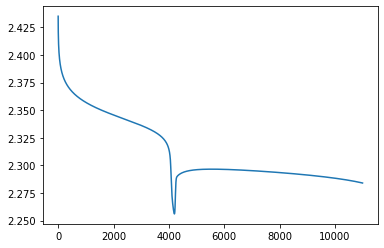

In [4]:
V_sol = solution["Terminal voltage [V]"]
t = solution.t
plt.plot(t,V_sol.data)

In [5]:
S8_initial = solution["S8 [g]"].data[-1]
S4_initial = solution["S4 [g]"].data[-1]
S2_initial = solution["S2 [g]"].data[-1]
S_initial = solution["S [g]"].data[-1]
Sp_initial = solution["Precipitated Sulfur [g]"].data[-1]
V_initial = solution["Terminal voltage [V]"].data[-1]
t_stop = solution.t[-1]

In [6]:
print(S8_initial)
print(S4_initial)
print(S2_initial)
print(S_initial)
print(Sp_initial)
print(V_initial)

7.36336740371016e-06
0.396331424420443
1.1531779041141017
0.00013286725171404875
1.1503504383627856
2.284020697876553


In [7]:
model2 = pybamm.BaseModel()

V = pybamm.Variable("Terminal voltage [V]")
model2.variables = {"Terminal voltage [V]": V}
#I = pybamm.Parameter("Current [A]")
#model.variables.update({"Current [A]": I})

# standard parameters
R = pybamm.Scalar(pybamm.parameters.constants.R.value)
F = pybamm.Scalar(pybamm.parameters.constants.F.value)
T = pybamm.Scalar(298)

Ms =  pybamm.Scalar(32)
ns = pybamm.Scalar(1)
ns2 = pybamm.Scalar(2)
ns4 = pybamm.Scalar(4)
ns8 = pybamm.Scalar(8)
ne = pybamm.Scalar(4)
ih0 = pybamm.Scalar(10)
il0 = pybamm.Scalar(5)
ar = pybamm.Scalar(0.960)
m_s = pybamm.Scalar(2.7)
rho_s = pybamm.Scalar(2 * (10 ** 3))
v = pybamm.Scalar(0.0114)
V_min = pybamm.Scalar(2.15)
V_max = pybamm.Scalar(2.5)
EH0 = pybamm.Scalar(2.35)
EL0 = pybamm.Scalar(2.195)
k_p = pybamm.Scalar(100)
S_star = pybamm.Scalar(0.0001)
k_s_charge =  pybamm.Scalar(0.0002)
k_s_discharge = pybamm.Scalar(0)
I = 1

i_coef = ne * F / (2 * R * T)
E_H_coef = R * T / (4 * F)
f_h = (ns4 ** 2) * Ms * v / ns8
f_l = (ns ** 2) * ns2 * Ms ** 2 * (v ** 2) / ns4

#######################################################
# Non-dynamic model functions
#######################################################

def E_H(data):
    """
    High plateau potenital [V] as defined by equation (2a) in [1]

    Input
    -------
    data : tuple
        Contains species S8, S4, S2, S, Sp, and voltage V. Each species term and
        the voltage can be a scalar or array.

    Output
    -------
    High plateau potential [V] : pybamm.Variable

    """
    # unpack data list
    S8, S4, S2, S, Sp, V = data

    return EH0 + E_H_coef * pybamm.log(f_h * S8 / (S4 ** 2))

def E_L(data):
    """
    Low plateau potenital [V] as defined by equation (2b) in [1]

    Inputs
    -------
    data : tuple
        Contains species S8, S4, S2, S, Sp, and voltage V. Each species term and
        the voltage can be a scalar or array.

    Output
    -------
    Low plateau potential [V] : pybamm.Variable

    """

    # unpack data list
    S8, S4, S2, S, Sp, V = data

    return EL0 + E_H_coef * pybamm.log(f_l * S4 / (S2 * (S ** 2)))

# Surface Overpotentials

def eta_H(data):
    """
    High plateau over-potenital [V] as defined by equation (6a) in [1]

    Input
    -------
    data : tuple
        Contains species S8, S4, S2, S, Sp, and voltage V. Each species term and
        the voltage can be a scalar or array.

    Output
    -------
    High plateau over-potential [V] : pybamm.Variable

    """

    # unpack data list
    S8, S4, S2, S, Sp, V = data

    return V - E_H(data)

def eta_L(data):
    """
    Low plateau over-potenital [V] as defined by equation (6b) in [1]

    Input
    -------
    data : tuple
        Contains species S8, S4, S2, S, Sp, and voltage V. Each species term and
        the voltage can be a scalar or array.

    Output
    -------
    Low plateau over-potential [V] : pybamm.Variable

    """

    # unpack data list
    S8, S4, S2, S, Sp, V = data

    return V - E_L(data)

# Half-cell Currents

def i_H(data):
    """
    High plateau current [A] as defined by equation (5a) in [1]

    Input
    -------
    data : tuple
        Contains species S8, S4, S2, S, Sp and voltage V. Each species term and
        the voltage can be a scalar or array.

    Output
    -------
    High plateau current [A] : pybamm.Variable

    """

    S8, S4, S2, S, Sp, V = data

    return -2 * ih0 * ar * pybamm.sinh(i_coef * eta_H(data))

def i_L(data):
    """
    Low plateau current [A] as defined by equation (5b) in [1]

    Input
    -------
    data : tuple
        Contains species S8, S4, S2, S, Sp and voltage V. Each species term and
        the voltage can be a scalar or array.

    Output
    -------
        Low plateau current [A] : pybamm.Variable

    """

    S8, S4, S2, S, Sp, V = data

    return -2 * il0 * ar * pybamm.sinh(i_coef * eta_L(data))

def cth(data):
    """
    Theoretical capacity [Ah] of the cell as defined by equation (2) in [2].

    Input
    -------
    data : tuple
        Contains species S8, S4, S2, S, Sp and voltage V. Each species term and
        the voltage can be a scalar or array.

    Output
    -------
    Theoretical capacity [Ah] : pybamm.Variable

    """

    S8, S4, S2, S, Sp, V = data

    return (3 * ne * F * S8 / (ns8 * Ms) + ne * F * S4 / (ns4 * Ms)) / 3600

def k_s_func(data):

    # represent the step function by a steep logistic curve
    return k_s_discharge + (k_s_charge - k_s_discharge) / (
        1 + pybamm.exp(10 * (i_H(data) + i_L(data)))
    )

###################################
# Dynamic model functions
###################################

def algebraic_condition_func(S8, S4, S2, S, Sp, V):
    """
    Algebraic constraint on currents as defined by equation (7) in [1]

    Input
    -------
    S8, S4, S2, S, Sp, V : pybamm.Variable
        Sulfur species [g] and Terminal voltage [V]

    Output
    -------
    pybamm.Variable
        Should equal to zero if condition is satisfied.

    """

    # pack data list
    data = S8, S4, S2, S, Sp, V

    return i_H(data) + i_L(data) - I

# RHS of ODE functions
def f8(S8, S4, S2, S, Sp, V):
    """
    RHS of differential equation (8a) in [1]

    Input
    -------
    S8, S4, S2, S, Sp, V : pybamm.Variable
        Sulfur species [g] and Terminal voltage [V].
        Scalar or array dependent on species/voltage type.

    Output
    -------
    pybamm.Variable
        Scalar or array dependent on species/voltage type.

    """

    # pack data list
    data = S8, S4, S2, S, Sp, V

    return -(ns8 * Ms * i_H(data) / (ne * F)) - k_s_func(data) * S8

def f4(S8, S4, S2, S, Sp, V):
    """
    RHS of differential equation (8b) in [1]

    Inputs
    --------
    S8, S4, S2, S, Sp, V : pybamm.Variable
        Sulfur species [g] and Terminal voltage [V].
        Scalar or array dependent on species/voltage type.

    Output
    -------
    pybamm.Variable
        Scalar or array dependent on species/voltage type.

    """

    # pack data list
    data = S8, S4, S2, S, Sp, V

    return (
        (ns8 * Ms * i_H(data) / (ne * F))
        + k_s_func(data) * S8
        - (ns4 * Ms * i_L(data) / (ne * F))
    )

def f2(S8, S4, S2, S, Sp, V):
    """
    RHS of differential equation (8c) in [1]

    Inputs
    -------
    S8, S4, S2, S, Sp, V : pybamm.Variable
        Sulfur species [g] and Terminal voltage [V].
        Scalar or array dependent on species/voltage type.

    Output
    -------
    pybamm.Variable
        Scalar or array dependent on species/voltage type.

    """

    # pack data list
    data = S8, S4, S2, S, Sp, V

    return ns2 * Ms * i_L(data) / (ne * F)

def f(S8, S4, S2, S, Sp, V):
    """
    RHS of differential equation (8d) in [1]

    Inputs
    -------
    S8, S4, S2, S, Sp, V : pybamm.Variable
        Sulfur species [g] and Terminal voltage [V].
        Scalar or array dependent on species/voltage type.

    Output
    -------
    pybamm.Variable
        Scalar or array dependent on species/voltage type.

    """

    # pack data list
    data = S8, S4, S2, S, Sp, V

    return (2 * ns * Ms * i_L(data) / (ne * F)) - k_p * Sp * (S - S_star) / (
        v * rho_s
    )

def fp(S8, S4, S2, S, Sp, V):
    """
    RHS of differential equation (8e) in [1]

    Inputs
    -------
    S8, S4, S2, S, Sp, V : pybamm.Variable
        Sulfur species [g] and Terminal voltage [V].
        Scalar or array dependent on species/voltage type.

    Output
    -------
    pybamm.Variable
        Scalar or array dependent on species/voltage type.

    """

    return k_p * Sp * (S - S_star) / (v * rho_s)

##############################
# model variables
#############################

# dynamic variables
S8 = pybamm.Variable("S8 [g]")
S4 = pybamm.Variable("S4 [g]")
S2 = pybamm.Variable("S2 [g]")
S = pybamm.Variable("S [g]")
Sp = pybamm.Variable("Precipitated Sulfur [g]")
alg = pybamm.Variable("Algebraic condition [-]")
k_s = pybamm.Variable("Shuttle coefficient [s-1]")
Sr = pybamm.Variable("Shuttle rate [g-1.s-1]")

model2.variables.update(
    {
        "S8 [g]": S8,
        "S4 [g]": S4,
        "S2 [g]": S2,
        "S [g]": S,
        "Precipitated Sulfur [g]": Sp,
        "Shuttle coefficient [s-1]": k_s_func((S8, S4, S2, S, Sp, V)),
        "Shuttle rate [g-1.s-1]": k_s_func((S8, S4, S2, S, Sp, V)) * S8,
        "High plateau potential [V]": E_H((S8, S4, S2, S, Sp, V)),
        "Low plateau potential [V]": E_L((S8, S4, S2, S, Sp, V)),
        "High plateau over-potential [V]": eta_H((S8, S4, S2, S, Sp, V)),
        "Low plateau over-potential [V]": eta_L((S8, S4, S2, S, Sp, V)),
        "High plateau current [A]": i_H((S8, S4, S2, S, Sp, V)),
        "Low plateau current [A]": i_L((S8, S4, S2, S, Sp, V)),
        "Theoretical capacity [Ah]": cth((S8, S4, S2, S, Sp, V)),
        "Algebraic condition [-]": algebraic_condition_func(
            S8, S4, S2, S, Sp, V
        ),
    }
)

#####################################
# Dynamic model equations
#####################################

# ODEs
dS8dt = f8(S8, S4, S2, S, Sp, V)
dS4dt = f4(S8, S4, S2, S, Sp, V)
dS2dt = f2(S8, S4, S2, S, Sp, V)
dSpdt = fp(S8, S4, S2, S, Sp, V)
dSdt = f(S8, S4, S2, S, Sp, V)

model2.rhs = {S8: dS8dt, S4: dS4dt, S2: dS2dt, S: dSdt, Sp: dSpdt}

# Algebraic Condition
algebraic_condition = algebraic_condition_func(S8, S4, S2, S, Sp, V)

model2.algebraic.update({V: algebraic_condition})

######################################
# Discharge initial condition
######################################
"""
Sets the initial species and voltage for discharge

The values are found by considering the zero-current
state of the battery. Set S8, S4, and Sp as written
below. Then, solve eta_H = V, eta_L = V, the algebraic
condition, and mass conservation for the remaining values.

"""


model2.initial_conditions.update(
    {
        model2.variables["S8 [g]"]: pybamm.Scalar(S8_initial),
        model2.variables["S4 [g]"]: pybamm.Scalar(S4_initial),
        model2.variables["S2 [g]"]: pybamm.Scalar(S2_initial),
        model2.variables["S [g]"]: pybamm.Scalar(S_initial),
        model2.variables["Precipitated Sulfur [g]"]: pybamm.Scalar(Sp_initial),
        model2.variables["Terminal voltage [V]"]: pybamm.Scalar(V_initial),
    }
)

disc = pybamm.Discretisation()  # use the default discretisation
disc.process_model(model2);

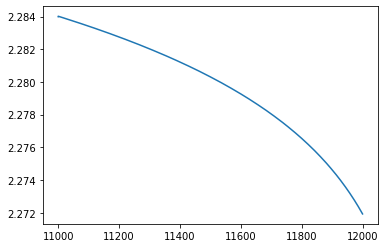

In [8]:
solver = pybamm.ScikitsDaeSolver()
t_new = np.linspace(t_stop, t_stop + 1000, 10000)
solution1 = solver.solve(model2, t_new)
V_ext = solution1["Terminal voltage [V]"].data
plt.plot(solution1.t,V_ext)

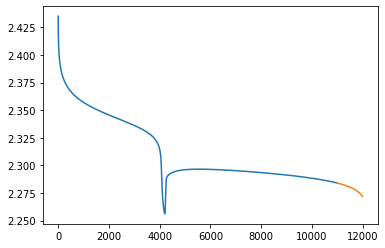

In [9]:
plt.plot(solution.t,V_sol.data)
plt.plot(solution1.t, V_ext)

In [10]:
S8_initial = solution1["S8 [g]"].data[-1]
S4_initial = solution1["S4 [g]"].data[-1]
S2_initial = solution1["S2 [g]"].data[-1]
S_initial = solution1["S [g]"].data[-1]
Sp_initial = solution1["Precipitated Sulfur [g]"].data[-1]
V_initial = solution1["Terminal voltage [V]"].data[-1]
t_stop = solution1.t[-1]

In [11]:
model3 = pybamm.BaseModel()

V = pybamm.Variable("Terminal voltage [V]")
model3.variables = {"Terminal voltage [V]": V}
#I = pybamm.Parameter("Current [A]")
#model.variables.update({"Current [A]": I})

# standard parameters
R = pybamm.Scalar(pybamm.parameters.constants.R.value)
F = pybamm.Scalar(pybamm.parameters.constants.F.value)
T = pybamm.Scalar(298)

Ms =  pybamm.Scalar(32)
ns = pybamm.Scalar(1)
ns2 = pybamm.Scalar(2)
ns4 = pybamm.Scalar(4)
ns8 = pybamm.Scalar(8)
ne = pybamm.Scalar(4)
ih0 = pybamm.Scalar(10)
il0 = pybamm.Scalar(5)
ar = pybamm.Scalar(0.960)
m_s = pybamm.Scalar(2.7)
rho_s = pybamm.Scalar(2 * (10 ** 3))
v = pybamm.Scalar(0.0114)
V_min = pybamm.Scalar(2.15)
V_max = pybamm.Scalar(2.5)
EH0 = pybamm.Scalar(2.35)
EL0 = pybamm.Scalar(2.195)
k_p = pybamm.Scalar(100)
S_star = pybamm.Scalar(0.0001)
k_s_charge =  pybamm.Scalar(0.0002)
k_s_discharge = pybamm.Scalar(0)
I = 1

i_coef = ne * F / (2 * R * T)
E_H_coef = R * T / (4 * F)
f_h = (ns4 ** 2) * Ms * v / ns8
f_l = (ns ** 2) * ns2 * Ms ** 2 * (v ** 2) / ns4

#######################################################
# Non-dynamic model functions
#######################################################

def E_H(data):
    """
    High plateau potenital [V] as defined by equation (2a) in [1]

    Input
    -------
    data : tuple
        Contains species S8, S4, S2, S, Sp, and voltage V. Each species term and
        the voltage can be a scalar or array.

    Output
    -------
    High plateau potential [V] : pybamm.Variable

    """
    # unpack data list
    S8, S4, S2, S, Sp, V = data

    return EH0 + E_H_coef * pybamm.log(f_h * S8 / (S4 ** 2))

def E_L(data):
    """
    Low plateau potenital [V] as defined by equation (2b) in [1]

    Inputs
    -------
    data : tuple
        Contains species S8, S4, S2, S, Sp, and voltage V. Each species term and
        the voltage can be a scalar or array.

    Output
    -------
    Low plateau potential [V] : pybamm.Variable

    """

    # unpack data list
    S8, S4, S2, S, Sp, V = data

    return EL0 + E_H_coef * pybamm.log(f_l * S4 / (S2 * (S ** 2)))

# Surface Overpotentials

def eta_H(data):
    """
    High plateau over-potenital [V] as defined by equation (6a) in [1]

    Input
    -------
    data : tuple
        Contains species S8, S4, S2, S, Sp, and voltage V. Each species term and
        the voltage can be a scalar or array.

    Output
    -------
    High plateau over-potential [V] : pybamm.Variable

    """

    # unpack data list
    S8, S4, S2, S, Sp, V = data

    return V - E_H(data)

def eta_L(data):
    """
    Low plateau over-potenital [V] as defined by equation (6b) in [1]

    Input
    -------
    data : tuple
        Contains species S8, S4, S2, S, Sp, and voltage V. Each species term and
        the voltage can be a scalar or array.

    Output
    -------
    Low plateau over-potential [V] : pybamm.Variable

    """

    # unpack data list
    S8, S4, S2, S, Sp, V = data

    return V - E_L(data)

# Half-cell Currents

def i_H(data):
    """
    High plateau current [A] as defined by equation (5a) in [1]

    Input
    -------
    data : tuple
        Contains species S8, S4, S2, S, Sp and voltage V. Each species term and
        the voltage can be a scalar or array.

    Output
    -------
    High plateau current [A] : pybamm.Variable

    """

    S8, S4, S2, S, Sp, V = data

    return -2 * ih0 * ar * pybamm.sinh(i_coef * eta_H(data))

def i_L(data):
    """
    Low plateau current [A] as defined by equation (5b) in [1]

    Input
    -------
    data : tuple
        Contains species S8, S4, S2, S, Sp and voltage V. Each species term and
        the voltage can be a scalar or array.

    Output
    -------
        Low plateau current [A] : pybamm.Variable

    """

    S8, S4, S2, S, Sp, V = data

    return -2 * il0 * ar * pybamm.sinh(i_coef * eta_L(data))

def cth(data):
    """
    Theoretical capacity [Ah] of the cell as defined by equation (2) in [2].

    Input
    -------
    data : tuple
        Contains species S8, S4, S2, S, Sp and voltage V. Each species term and
        the voltage can be a scalar or array.

    Output
    -------
    Theoretical capacity [Ah] : pybamm.Variable

    """

    S8, S4, S2, S, Sp, V = data

    return (3 * ne * F * S8 / (ns8 * Ms) + ne * F * S4 / (ns4 * Ms)) / 3600

def k_s_func(data):

    # represent the step function by a steep logistic curve
    return k_s_discharge + (k_s_charge - k_s_discharge) / (
        1 + pybamm.exp(10 * (i_H(data) + i_L(data)))
    )

###################################
# Dynamic model functions
###################################

def algebraic_condition_func(S8, S4, S2, S, Sp, V):
    """
    Algebraic constraint on currents as defined by equation (7) in [1]

    Input
    -------
    S8, S4, S2, S, Sp, V : pybamm.Variable
        Sulfur species [g] and Terminal voltage [V]

    Output
    -------
    pybamm.Variable
        Should equal to zero if condition is satisfied.

    """

    # pack data list
    data = S8, S4, S2, S, Sp, V

    return i_H(data) + i_L(data) - I

# RHS of ODE functions
def f8(S8, S4, S2, S, Sp, V):
    """
    RHS of differential equation (8a) in [1]

    Input
    -------
    S8, S4, S2, S, Sp, V : pybamm.Variable
        Sulfur species [g] and Terminal voltage [V].
        Scalar or array dependent on species/voltage type.

    Output
    -------
    pybamm.Variable
        Scalar or array dependent on species/voltage type.

    """

    # pack data list
    data = S8, S4, S2, S, Sp, V

    return -(ns8 * Ms * i_H(data) / (ne * F)) - k_s_func(data) * S8

def f4(S8, S4, S2, S, Sp, V):
    """
    RHS of differential equation (8b) in [1]

    Inputs
    --------
    S8, S4, S2, S, Sp, V : pybamm.Variable
        Sulfur species [g] and Terminal voltage [V].
        Scalar or array dependent on species/voltage type.

    Output
    -------
    pybamm.Variable
        Scalar or array dependent on species/voltage type.

    """

    # pack data list
    data = S8, S4, S2, S, Sp, V

    return (
        (ns8 * Ms * i_H(data) / (ne * F))
        + k_s_func(data) * S8
        - (ns4 * Ms * i_L(data) / (ne * F))
    )

def f2(S8, S4, S2, S, Sp, V):
    """
    RHS of differential equation (8c) in [1]

    Inputs
    -------
    S8, S4, S2, S, Sp, V : pybamm.Variable
        Sulfur species [g] and Terminal voltage [V].
        Scalar or array dependent on species/voltage type.

    Output
    -------
    pybamm.Variable
        Scalar or array dependent on species/voltage type.

    """

    # pack data list
    data = S8, S4, S2, S, Sp, V

    return ns2 * Ms * i_L(data) / (ne * F)

def f(S8, S4, S2, S, Sp, V):
    """
    RHS of differential equation (8d) in [1]

    Inputs
    -------
    S8, S4, S2, S, Sp, V : pybamm.Variable
        Sulfur species [g] and Terminal voltage [V].
        Scalar or array dependent on species/voltage type.

    Output
    -------
    pybamm.Variable
        Scalar or array dependent on species/voltage type.

    """

    # pack data list
    data = S8, S4, S2, S, Sp, V

    return (2 * ns * Ms * i_L(data) / (ne * F)) - k_p * Sp * (S - S_star) / (
        v * rho_s
    )

def fp(S8, S4, S2, S, Sp, V):
    """
    RHS of differential equation (8e) in [1]

    Inputs
    -------
    S8, S4, S2, S, Sp, V : pybamm.Variable
        Sulfur species [g] and Terminal voltage [V].
        Scalar or array dependent on species/voltage type.

    Output
    -------
    pybamm.Variable
        Scalar or array dependent on species/voltage type.

    """

    return k_p * Sp * (S - S_star) / (v * rho_s)

##############################
# model variables
#############################

# dynamic variables
S8 = pybamm.Variable("S8 [g]")
S4 = pybamm.Variable("S4 [g]")
S2 = pybamm.Variable("S2 [g]")
S = pybamm.Variable("S [g]")
Sp = pybamm.Variable("Precipitated Sulfur [g]")
alg = pybamm.Variable("Algebraic condition [-]")
k_s = pybamm.Variable("Shuttle coefficient [s-1]")
Sr = pybamm.Variable("Shuttle rate [g-1.s-1]")

model3.variables.update(
    {
        "S8 [g]": S8,
        "S4 [g]": S4,
        "S2 [g]": S2,
        "S [g]": S,
        "Precipitated Sulfur [g]": Sp,
        "Shuttle coefficient [s-1]": k_s_func((S8, S4, S2, S, Sp, V)),
        "Shuttle rate [g-1.s-1]": k_s_func((S8, S4, S2, S, Sp, V)) * S8,
        "High plateau potential [V]": E_H((S8, S4, S2, S, Sp, V)),
        "Low plateau potential [V]": E_L((S8, S4, S2, S, Sp, V)),
        "High plateau over-potential [V]": eta_H((S8, S4, S2, S, Sp, V)),
        "Low plateau over-potential [V]": eta_L((S8, S4, S2, S, Sp, V)),
        "High plateau current [A]": i_H((S8, S4, S2, S, Sp, V)),
        "Low plateau current [A]": i_L((S8, S4, S2, S, Sp, V)),
        "Theoretical capacity [Ah]": cth((S8, S4, S2, S, Sp, V)),
        "Algebraic condition [-]": algebraic_condition_func(
            S8, S4, S2, S, Sp, V
        ),
    }
)

#####################################
# Dynamic model equations
#####################################

# ODEs
dS8dt = f8(S8, S4, S2, S, Sp, V)
dS4dt = f4(S8, S4, S2, S, Sp, V)
dS2dt = f2(S8, S4, S2, S, Sp, V)
dSpdt = fp(S8, S4, S2, S, Sp, V)
dSdt = f(S8, S4, S2, S, Sp, V)

model3.rhs = {S8: dS8dt, S4: dS4dt, S2: dS2dt, S: dSdt, Sp: dSpdt}

# Algebraic Condition
algebraic_condition = algebraic_condition_func(S8, S4, S2, S, Sp, V)

model3.algebraic.update({V: algebraic_condition})

######################################
# Discharge initial condition
######################################
"""
Sets the initial species and voltage for discharge

The values are found by considering the zero-current
state of the battery. Set S8, S4, and Sp as written
below. Then, solve eta_H = V, eta_L = V, the algebraic
condition, and mass conservation for the remaining values.

"""


model3.initial_conditions.update(
    {
        model3.variables["S8 [g]"]: pybamm.Scalar(S8_initial),
        model3.variables["S4 [g]"]: pybamm.Scalar(S4_initial),
        model3.variables["S2 [g]"]: pybamm.Scalar(S2_initial),
        model3.variables["S [g]"]: pybamm.Scalar(S_initial),
        model3.variables["Precipitated Sulfur [g]"]: pybamm.Scalar(Sp_initial),
        model3.variables["Terminal voltage [V]"]: pybamm.Scalar(V_initial),
    }
)

disc = pybamm.Discretisation()  # use the default discretisation
disc.process_model(model3);

solver = pybamm.ScikitsDaeSolver()
t_new2 = np.linspace(t_stop, t_stop + 1, 10000)
solution2 = solver.solve(model3, t_new)
V_ext2 = solution2["Terminal voltage [V]"].data
plt.plot(solution2.t,V_ext2)

SolverError: Convergence test failures occurred too many times during one internal time step or minimum step size was reached.